# 2. Analysis of Home Advantage

Looks at whether the home team has some advantage and if that changed before and after the bubble.

Look at home team winning percentage before and after the bubble using:
- graphing home winning percentage by date
- t-test of before and after bubble
- bayesian model of when winning percentage changes

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Read in and Manipulate Data

In [2]:
# Read in data
schedule = pd.read_csv('data/schedule_2020.csv')
# team_perf = pd.read_csv('data/team_perf_2020.csv')
# player_info = pd.read_csv('data/players_2020.csv')
# player_perf = pd.read_csv('data/player_perf_2020.csv')

In [3]:
# convert date to date type
schedule['Date'] = pd.to_datetime(schedule['Date'])

In [4]:
# add home team win indicator
schedule['home_win'] = schedule['Home Points'] > schedule['Visitor Points']
print (schedule['home_win'].value_counts())
print (schedule['home_win'].mean())

True     610
False    497
Name: home_win, dtype: int64
0.5510388437217706


In [5]:
schedule.groupby(['bubble', 'playoff']).agg({'home_win':'mean'})

home_win
bubble playoff          
0      0        0.550978
1      0        0.556818
       1        0.541667

## Graph of moving average of winning percentage

In [6]:
d = schedule.loc[20, 'Date']
print(d)
print(d-datetime.timedelta(days=10))

2019-10-25 00:00:00
2019-10-15 00:00:00


In [7]:
# calculate 10 day moving average of home winning percentage
schedule = schedule.sort_values('Date')
schedule['home_win_p_ma_10'] = None
for idx, row in schedule.iterrows():
    subset = schedule.loc[(schedule['Date']<=row['Date']) & (schedule['Date']>=(row['Date'] - datetime.timedelta(days=10)))]
    schedule.loc[idx, 'home_win_p_ma_10'] = subset['home_win'].mean()
    

In [8]:
# reduce to unique dates
h_win_per_date = schedule.groupby('Date').agg({'home_win_p_ma_10':'max'}).reset_index()
h_win_per_date.head()

,Date,home_win_p_ma_10
0,2019-10-22,1.000000
1,2019-10-23,0.769231
2,2019-10-24,0.625000
3,2019-10-25,0.560000
4,2019-10-26,0.571429


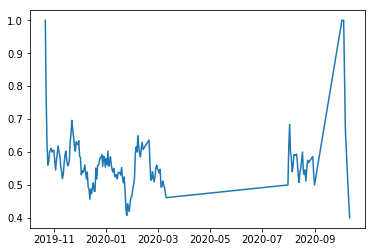

In [9]:
plt.plot(h_win_per_date['Date'], h_win_per_date['home_win_p_ma_10'])
plt.show()

## t-test of before and after the bubble

In [36]:
import statsmodels.api as sm

In [13]:
normal = schedule.loc[schedule['bubble']==0]['home_win']
bubble = schedule.loc[schedule['bubble']==1]['home_win']
test_stat, p_value = statsmodels.stats.weightstats.ztest(x1=normal, x2=bubble)
print (test_stat, p_value)

-0.010798721418801806 0.9913840343585684


In [ ]:
normal = schedule.loc[schedule['bubble']==0]['home_win']
bubble = schedule.loc[(schedule['bubble']==1) & (schedule['playoff']==0)]['home_win']
test_stat, p_value = statsmodels.stats.weightstats.ztest(x1=normal, x2=bubble)
print (test_stat, p_value)

## Bayesian Model of win rate

In [11]:
import pymc3 as pm
import theano.tensor as tt

In [45]:
# represent each win to follow a bernoulli probability with probability p
# p0 = normal(u,1)
# p1 = normal(u,1)
# switch over at tau which has a uniform distribution between 0 and 355

with pm.Model() as model:
    u = 0.55  # Recall count_data is the

    p_1 = pm.Normal("p_1", u)
    p_2 = pm.Normal("p_2", u)

    tau = pm.DiscreteUniform("tau", lower=0, upper=len(schedule))

In [46]:
with model:
    idx = np.arange(len(schedule_v2)) # Index
    p_ = pm.math.switch(tau > idx, p_1, p_2)

In [47]:
with model:
    observation = pm.Bernoulli("obs", p_, observed=schedule['home_win'])

In [48]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [p_2]
>Metropolis: [p_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3314.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [49]:
p_1_samples = trace['p_1']
p_2_samples = trace['p_2']
tau_samples = trace['tau']

In [50]:
from IPython.core.pylabtools import figsize

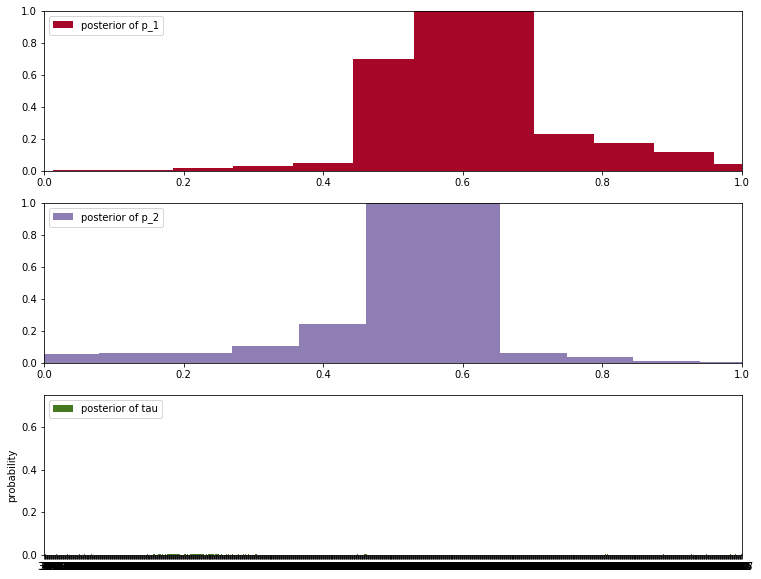

In [54]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(p_1_samples, histtype='stepfilled', bins=30,
         label="posterior of p_1", color="#A60628", density=True)
plt.legend(loc="upper left")
# plt.title(r"""Posterior distributions of the variables
#     p_1,\;\p_2,\;\tau$""")
plt.xlim([0, 1])
# plt.xlabel("$\p_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(p_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of p_2", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([0, 1])
# plt.xlabel("$\p_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=len(schedule_v2), alpha=1,
         label=r"posterior of tau",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(len(schedule_v2)))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(schedule_v2)-20])
# plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

## Paired t-test

In [61]:
# create columns for pre-bubble and post-bubble wins
schedule_by_team = schedule.groupby(['Home Team', 'bubble']).agg({'home_win':'mean'}).reset_index()
schedule_by_team_pre = schedule_by_team.loc[schedule_by_team['bubble']==0]
schedule_by_team_bubble = schedule_by_team.loc[schedule_by_team['bubble']==1]
perf_by_team = pd.merge(schedule_by_team_pre, schedule_by_team_bubble, on='Home Team', how='outer', suffixes=['_pre', '_bubble'])
perf_by_team.head()

,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble
0,Atlanta Hawks,0,0.411765,NaN,NaN
1,Boston Celtics,0,0.718750,1.0,0.833333
2,Brooklyn Nets,0,0.562500,1.0,0.333333
3,Charlotte Hornets,0,0.322581,NaN,NaN
4,Chicago Bulls,0,0.411765,NaN,NaN


In [62]:
# filter out teams that weren't in the bubble
no_bubble = perf_by_team.loc[pd.isnull(perf_by_team['home_win_bubble'])]
no_bubble

,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble
0,Atlanta Hawks,0,0.411765,NaN,NaN
3,Charlotte Hornets,0,0.322581,NaN,NaN
4,Chicago Bulls,0,0.411765,NaN,NaN
5,Cleveland Cavaliers,0,0.305556,NaN,NaN
8,Detroit Pistons,0,0.333333,NaN,NaN
9,Golden State Warriors,0,0.235294,NaN,NaN
17,Minnesota Timberwolves,0,0.250000,NaN,NaN
19,New York Knicks,0,0.333333,NaN,NaN


In [66]:
# format by team
perf_by_team_clean = perf_by_team.loc[~pd.isnull(perf_by_team['home_win_bubble'])]
perf_by_team_clean['home_win_diff'] = perf_by_team_clean['home_win_bubble'] - perf_by_team_clean['home_win_pre']
perf_by_team_clean.head()

/Users/matt/anaconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble,home_win_diff
1,Boston Celtics,0,0.718750,1.0,0.833333,0.114583
2,Brooklyn Nets,0,0.562500,1.0,0.333333,-0.229167
6,Dallas Mavericks,0,0.558824,1.0,0.285714,-0.273109
7,Denver Nuggets,0,0.757576,1.0,0.428571,-0.329004
10,Houston Rockets,0,0.687500,1.0,0.714286,0.026786


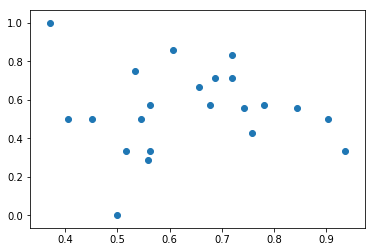

In [69]:
# visually inspect difference in win percentages by team
plt.scatter(perf_by_team_clean['home_win_pre'], perf_by_team_clean['home_win_bubble'])

In [70]:
# run a paired t-test
tstat, pvalue, df = statsmodels.stats.weightstats.ttest_ind(x1=perf_by_team_clean['home_win_pre'], x2=perf_by_team_clean['home_win_bubble'])
print (tstat, pvalue)

1.5537694397220425 0.1277432549211029


In [71]:
# find which teams did exceptionally different
perf_by_team_clean['home_win_diff_abs'] = [abs(x) for x in perf_by_team_clean['home_win_diff']]
perf_by_team_clean.sort_values('home_win_diff_abs', ascending=False).head(10)

/Users/matt/anaconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble,home_win_diff,home_win_diff_abs
23,Phoenix Suns,0,0.371429,1.0,1.000000,0.628571,0.628571
22,Philadelphia 76ers,0,0.935484,1.0,0.333333,-0.602151,0.602151
29,Washington Wizards,0,0.500000,1.0,0.000000,-0.500000,0.500000
16,Milwaukee Bucks,0,0.903226,1.0,0.500000,-0.403226,0.403226
7,Denver Nuggets,0,0.757576,1.0,0.428571,-0.329004,0.329004
15,Miami Heat,0,0.843750,1.0,0.555556,-0.288194,0.288194
6,Dallas Mavericks,0,0.558824,1.0,0.285714,-0.273109,0.273109
20,Oklahoma City Thunder,0,0.606061,1.0,0.857143,0.251082,0.251082
2,Brooklyn Nets,0,0.562500,1.0,0.333333,-0.229167,0.229167
26,San Antonio Spurs,0,0.533333,1.0,0.750000,0.216667,0.216667


## Repeat paired t-test but filter out playoffs

In [72]:
# create columns for pre-bubble and post-bubble wins
schedule_by_team = schedule.loc[schedule['playoff']==0].groupby(['Home Team', 'bubble']).agg({'home_win':'mean'}).reset_index()
schedule_by_team_pre = schedule_by_team.loc[schedule_by_team['bubble']==0]
schedule_by_team_bubble = schedule_by_team.loc[schedule_by_team['bubble']==1]
perf_by_team = pd.merge(schedule_by_team_pre, schedule_by_team_bubble, on='Home Team', how='outer', suffixes=['_pre', '_bubble'])
perf_by_team.head()

,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble
0,Atlanta Hawks,0,0.411765,NaN,NaN
1,Boston Celtics,0,0.718750,1.0,0.75
2,Brooklyn Nets,0,0.562500,1.0,0.50
3,Charlotte Hornets,0,0.322581,NaN,NaN
4,Chicago Bulls,0,0.411765,NaN,NaN


In [73]:
# filter out teams that weren't in the bubble
no_bubble = perf_by_team.loc[pd.isnull(perf_by_team['home_win_bubble'])]
no_bubble

,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble
0,Atlanta Hawks,0,0.411765,NaN,NaN
3,Charlotte Hornets,0,0.322581,NaN,NaN
4,Chicago Bulls,0,0.411765,NaN,NaN
5,Cleveland Cavaliers,0,0.305556,NaN,NaN
8,Detroit Pistons,0,0.333333,NaN,NaN
9,Golden State Warriors,0,0.235294,NaN,NaN
17,Minnesota Timberwolves,0,0.250000,NaN,NaN
19,New York Knicks,0,0.333333,NaN,NaN


In [74]:
# format by team
perf_by_team_clean = perf_by_team.loc[~pd.isnull(perf_by_team['home_win_bubble'])]
perf_by_team_clean['home_win_diff'] = perf_by_team_clean['home_win_bubble'] - perf_by_team_clean['home_win_pre']
perf_by_team_clean.head()

/Users/matt/anaconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble,home_win_diff
1,Boston Celtics,0,0.718750,1.0,0.75,0.031250
2,Brooklyn Nets,0,0.562500,1.0,0.50,-0.062500
6,Dallas Mavericks,0,0.558824,1.0,0.25,-0.308824
7,Denver Nuggets,0,0.757576,1.0,0.25,-0.507576
10,Houston Rockets,0,0.687500,1.0,0.50,-0.187500


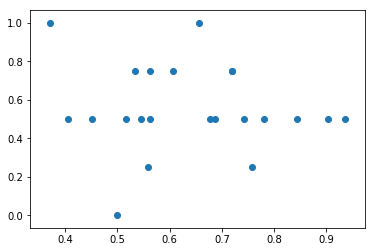

In [75]:
# visually inspect difference in win percentages by team
plt.scatter(perf_by_team_clean['home_win_pre'], perf_by_team_clean['home_win_bubble'])

In [76]:
# run a paired t-test
tstat, pvalue, df = statsmodels.stats.weightstats.ttest_ind(x1=perf_by_team_clean['home_win_pre'], x2=perf_by_team_clean['home_win_bubble'])
print (tstat, pvalue)

1.3742230832310598 0.17666175649188454


In [77]:
# find which teams did exceptionally different
perf_by_team_clean['home_win_diff_abs'] = [abs(x) for x in perf_by_team_clean['home_win_diff']]
perf_by_team_clean.sort_values('home_win_diff_abs', ascending=False).head(10)

/Users/matt/anaconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Home Team,bubble_pre,home_win_pre,bubble_bubble,home_win_bubble,home_win_diff,home_win_diff_abs
23,Phoenix Suns,0,0.371429,1.0,1.00,0.628571,0.628571
7,Denver Nuggets,0,0.757576,1.0,0.25,-0.507576,0.507576
29,Washington Wizards,0,0.500000,1.0,0.00,-0.500000,0.500000
22,Philadelphia 76ers,0,0.935484,1.0,0.50,-0.435484,0.435484
16,Milwaukee Bucks,0,0.903226,1.0,0.50,-0.403226,0.403226
11,Indiana Pacers,0,0.656250,1.0,1.00,0.343750,0.343750
15,Miami Heat,0,0.843750,1.0,0.50,-0.343750,0.343750
6,Dallas Mavericks,0,0.558824,1.0,0.25,-0.308824,0.308824
12,Los Angeles Clippers,0,0.781250,1.0,0.50,-0.281250,0.281250
13,Los Angeles Lakers,0,0.741935,1.0,0.50,-0.241935,0.241935


## Conclusion

When looking at home win percentages at an aggregate level, there doesn't appear to be any difference in the bubble.  When looking at a team-level, however, there appears to be some differences, but those can likely be caused by random noise given the low amount of games played in the bubble